# Imports

In [1]:
from os import listdir
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization, concatenate, Softmax #, CuDNNLSTM, CuDNNGRU

from tensorflow_addons.metrics import F1Score

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# %matplotlib inline

# GPU Presence

In [4]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# Mount Drive For Google Colab

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# %cd drive/MyDrive/ECE542\ Project\ Competition/data

# Load Data

In [7]:
# Features of our data
features = ['x accelerometer', 'y accelerometer', 'z accelerometer', 'x gyroscope', 'y gyroscope', 'z gyroscope', 'label']

# Get names of training files
files = listdir('data/TrainingData')
files = ['data/TrainingData/' + name for name in files]

# Store data for each subject
subjects_dict = {}

for sub_num in range(1, 9):         # Subject A
    subjects_dict[str(sub_num)] = {}
    for trial_num in range(1, 10):     # Trial B
        prefix = 'data/TrainingData/subject_00{}_0{}__'.format(sub_num, trial_num)

        # Break if file does not exist
        if (prefix + 'x_time.csv') not in files:
            break

        ## X
        # Read subject_00A_0B__x_time.csv
        x_time = pd.read_csv(prefix + 'x_time.csv', names=['sec'])
        # Read subject_00A_0B__x.csv
        x_data = pd.read_csv(prefix + 'x.csv'.format(sub_num, trial_num), names=features[:-1])

        # Concatenate time with data, and set time as index
        x_result = pd.concat([x_time, x_data], axis=1)
        x_result = x_result.set_index('sec')

        ## Y
        # Read subject_00A_0B__y_time.csv
        y_time = pd.read_csv(prefix + 'y_time.csv'.format(sub_num, trial_num), names=['sec'])
        y_time.sec = y_time.sec - 0.02
        y_time = y_time.round(decimals=3)

        # Read subject_00A_0B__y.csv
        y_data = pd.read_csv(prefix + 'y.csv'.format(sub_num, trial_num), names=[features[-1]])

        # Concatenate time with label, and set time as index
        y_result = pd.concat([y_time, y_data], axis=1)
        y_result = y_result.set_index('sec')

        ## Now for the stupid part; need to shift y_result from 10Hz to 40Hz
        x_num_pts = x_data.shape[0]
        x_endtime = x_result.index[-1]

        time_temp = np.linspace(0, x_endtime, num=x_num_pts)
        time_temp = np.round(time_temp, decimals=3)

        # Convert above array into dataframe, and set time as index
        df_time_temp = pd.DataFrame(time_temp, columns=['sec'])
        df_time_temp = df_time_temp.set_index('sec')

        new_y_result = pd.concat([df_time_temp, y_result], axis=1)
        new_y_result = new_y_result.fillna(method='ffill')

        ## Create final dataframe with x and y in 40Hz
        result = pd.concat([x_result, new_y_result], axis=1)

        # Confirm that x and y are aligned
        assert x_num_pts == result.shape[0]
        assert x_endtime == result.index[-1]

        subjects_dict[str(sub_num)][str(trial_num)] = result

# Helper Functions

### Static Params

In [8]:
# Static Params
X_RATE = 40
Y_RATE = 10
NUM_SENSORS = 6
NUM_CLASS = 4

### Functions for Data Preparation

In [9]:
# Formats data into epochs, same as Matt's format_data
def format_data(data, data_params):
    window = data_params['window']
    stride = data_params['stride']
    
    num_epochs = int((data.index[-1] - window) / stride)
    x_epochs = np.zeros((num_epochs, window * X_RATE, NUM_SENSORS))
    y_epochs = np.zeros((num_epochs, NUM_CLASS))

    np_data = data[features].to_numpy()
    x_np, y_np = np_data[:, :-1], np_data[:, -1].astype(int)

    window_size = int(X_RATE * window)

    # window epoch calculation stuff
    for i in range(num_epochs):
        offset = int(X_RATE * stride * i)
        x_epochs[i] = x_np[offset : window_size + offset]
        y_epochs[i][y_np[window_size + offset]] = 1

    return x_epochs, y_epochs.astype(int)

# Shuffles Data with seed
def shuffle_data(x, y):
    shuffle = np.random.permutation(x.shape[0])
    x_shuf, y_shuf = x[shuffle], y[shuffle]
    return x_shuf, y_shuf

# Combine, format, and shuffles subjects data
def format_combine_shuffle(subjects_dict, subjects, data_params, shuffle, matt=False):
    x_seq, y_seq = None, None

    for sub in subjects:
        for trial, data in subjects_dict[sub].items():
            if matt:
                if trial == '1':
                    x_temp, y_temp = format_data(data, data_params)
                    if x_seq is None:
                        x_seq = x_temp
                        y_seq = y_temp
                    else:
                        x_seq = np.concatenate((x_seq, x_temp), axis=0)
                        y_seq = np.concatenate((y_seq, y_temp), axis=0)
            else:
                x_temp, y_temp = format_data(data, data_params)
                if x_seq is None:
                    x_seq = x_temp
                    y_seq = y_temp
                else:
                    x_seq = np.concatenate((x_seq, x_temp), axis=0)
                    y_seq = np.concatenate((y_seq, y_temp), axis=0)
    
    if shuffle:
        # seed = data_params['seed']
        x_seq, y_seq = shuffle_data(x_seq, y_seq)
    
    return x_seq, y_seq

### Functions for Model Training and Evaluation

In [10]:
def train_model(model, x_train, y_train, x_val, y_val, arch_params, fit_params, verbose=1):
    lr = fit_params['lr']
    epochs = fit_params['epochs']
    batch_size = fit_params['batch_size']
    weights = fit_params['weights']
    
    opt = Adam(learning_rate=lr)  #, amsgrad=True
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[F1Score(num_classes=NUM_CLASS, average='macro')])
    
    print(model.summary())
    
    history = None
    if weights is None:
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), 
                            verbose=verbose)
    else:
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), 
                            class_weight=weights, verbose=verbose)
    return model, history

def evaluate_model(x, y, model, plot=False, history=None, swap=False):
    yhat = model.predict(x)
    yhat_cf = np.argmax(yhat, axis=1)
    y_cf = np.argmax(y, axis=1)

    if history is not None:
        fig, axs = plt.subplots(1, 2, figsize=(14,6))
        
        axs[0].plot(history.history['f1_score'], label='Training')
        axs[0].plot(history.history['val_f1_score'], label='Validation')
        axs[0].set_title('Model F1-Score')
        axs[0].set_ylabel('F1-Score')
        axs[0].set_xlabel('Epochs')
        axs[0].legend()

        axs[1].plot(history.history['loss'], label='Training')
        axs[1].plot(history.history['val_loss'], label='Validation')
        axs[1].set_title('Model Loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epochs')
        axs[1].legend()
    
    if plot:
        print(f1_score(y_cf, yhat_cf, average='macro'))
        cm = confusion_matrix(y_cf, yhat_cf, normalize='true')
        if swap:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standing','Grass','Up Stairs','Down Stairs'])
        else:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standing','Down Stairs','Up Stairs','Grass'])
        disp.plot();
    else:
        print(f1_score(y_cf, yhat_cf, average='macro'))

In [11]:
def test_subject(model, subject, plot=True):
    x_seq, y_seq = None, None
    for trial, data in subjects_dict[subject].items():
        x_temp, y_temp = format_data(data, data_params)

        if trial == list(subjects_dict[subject].keys())[0]:
            x_seq = x_temp
            y_seq = y_temp
        else:
            x_seq = np.concatenate((x_seq, x_temp), axis=0)
            y_seq = np.concatenate((y_seq, y_temp), axis=0)

    print('\nSubject {}'.format(subject))
    evaluate_model(x_seq, y_seq, model, plot, history=None)

# Model Building, Training, & Evaluation

## Establishing Training and Testing Set

In [76]:
# Data Format Params
data_params = {'window': 2, 'stride': 0.2}

# Subjects to train on
sub_train = ['1', '2', '3', '4', '5', '6', '7', '8']
x_train, y_train = format_combine_shuffle(subjects_dict, sub_train, data_params, shuffle=True)

print('Training Shape:', x_train.shape)

# Subjects to train on
sub_test = ['4', '6']
x_test, y_test = format_combine_shuffle(subjects_dict, sub_test, data_params, shuffle=False)
_, x_val, _, y_val = train_test_split(x_test, y_test, test_size=0.3, shuffle=True)

print('Testing Shape:', x_test.shape)
print('Validation Shape:', x_val.shape)

Training Shape: (167400, 80, 6)
Testing Shape: (27648, 80, 6)
Validation Shape: (8295, 80, 6)


## Establishing Model Parameters and Model Building, Training, & Testing

### Matt's Model

In [66]:
LSTM_UNITS = 256
DROPOUT_1 = 0.3
DENSE_1 = 64
DROPOUT_2 = 0.3
arch_params_1 = {'layer1': LSTM_UNITS, 'layer2': DROPOUT_1, 'layer3': DENSE_1, 'layer4': DROPOUT_2}

INIT_LR = 0.0012
EPOCHS = 50
BATCH_SIZE = 32
fit_params_1 = {'lr': INIT_LR, 'epochs': EPOCHS, 'batch_size': BATCH_SIZE, 'weights': None}

# Model
model_1 = Sequential([
    LSTM(units=arch_params2['layer1'], input_shape=x_train.shape[1:], return_sequences=False),
    Dropout(rate=arch_params2['layer2']),
    Dense(units=arch_params2['layer3'], activation='relu'),
    Dropout(rate=arch_params2['layer4']),
    Dense(NUM_CLASS, activation='softmax')
])

In [67]:
# Train Model
model, history = train_model(model_1, x_train, y_train, x_val, y_val, arch_params_1, fit_params_1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               269312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 260       
Total params: 286,020
Trainable params: 286,020
Non-trainable params: 0
_________________________________________________________________
None
Train on 76222 samples, validate on 6876 samples
Epoch 1/50
76222/76222 [==============================] - 22

Epoch 48/50
76222/76222 [==============================] - 19s 254us/sample - loss: 0.0176 - f1_score: 0.9900 - val_loss: 2.1649 - val_f1_score: 0.6882
Epoch 49/50
76222/76222 [==============================] - 19s 255us/sample - loss: 0.0178 - f1_score: 0.9892 - val_loss: 1.8153 - val_f1_score: 0.7162
Epoch 50/50
76222/76222 [==============================] - 20s 259us/sample - loss: 0.0214 - f1_score: 0.9872 - val_loss: 1.3839 - val_f1_score: 0.7077


0.991167224156112


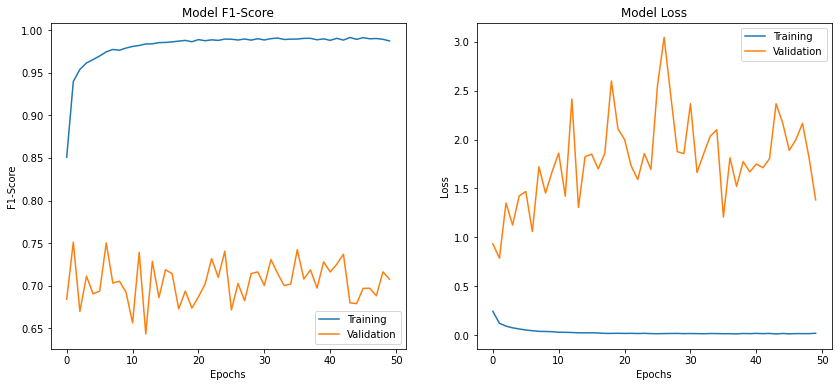

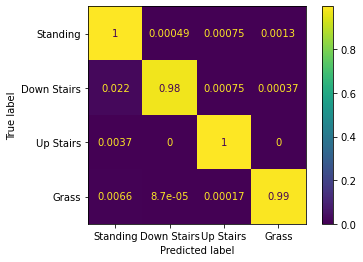

In [68]:
evaluate_model(x_train, y_train, model_1, True, history)

### Evaluation

0.7144327652721733


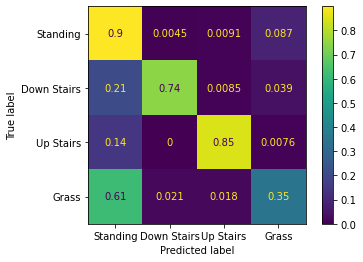

In [69]:
evaluate_model(x_test, y_test, model_1, plot=True, history=None)

In [70]:
for sub in sub_test:
    test_subject(model_1, sub, False)


Subject 1
0.7891848477701445

Subject 4
0.7985137848888286

Subject 8
0.4923207503537881



Subject 2
0.7476924332129162


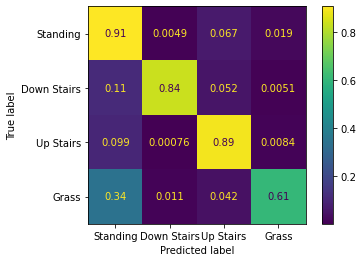

In [71]:
test_subject(model_1, '1')


Subject 4
0.7985137848888286


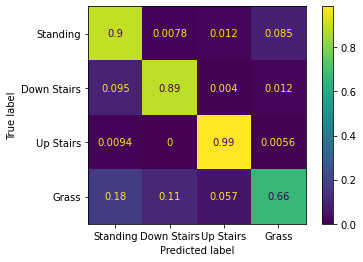

In [72]:
test_subject(model_1, '4')


Subject 8
0.4923207503537881


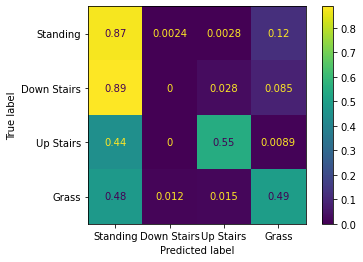

In [73]:
test_subject(model_1, '8')

### My Model

In [348]:
# Model Params
LSTM_L1 = 256
DENSE_L2 = 256
arch_params_2 = {'layer1': LSTM_L1, 'layer2': DENSE_L2}

INIT_LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
WEIGHTS = {0:1, 1:4, 2:4, 3:6}
fit_params_2 = {'lr': INIT_LR, 'epochs': EPOCHS, 'batch_size': BATCH_SIZE, 'weights': WEIGHTS}

# Model
model_2 = Sequential([
    # CuDNNGRU(units=80, input_shape=x_train.shape[1:], return_sequences=False),
    # CuDNNLSTM(units=80, input_shape=x_train.shape[1:], return_sequences=False),
    # GRU(units=arch_params['layer1'], input_shape=x_train.shape[1:], return_sequences=False),
    LSTM(units=arch_params_2['layer1'], input_shape=x_train.shape[1:], return_sequences=False),
    BatchNormalization(),
    Dense(units=arch_params_2['layer2'], activation='relu'),
    BatchNormalization(),
    Dense(NUM_CLASS, activation='softmax')
])

In [349]:
# Train Model
model_2, history = train_model(model_2, x_train, y_train, x_val, y_val, arch_params_2, fit_params_2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               269312    
_________________________________________________________________
batch_normalization_253 (Bat (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_254 (Bat (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 338,180
Trainable params: 337,156
Non-trainable params: 1,024
_________________________________________________________________
None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 45297 samples, validate on 3085 samples
Epoch 

Epoch 47/50
45297/45297 [==============================] - 13s 286us/sample - loss: 0.0274 - f1_score: 0.9902 - val_loss: 0.0055 - val_f1_score: 0.9977
Epoch 48/50
45297/45297 [==============================] - 13s 293us/sample - loss: 0.0197 - f1_score: 0.9936 - val_loss: 0.0227 - val_f1_score: 0.9936
Epoch 49/50
45297/45297 [==============================] - 14s 302us/sample - loss: 0.0279 - f1_score: 0.9925 - val_loss: 0.0169 - val_f1_score: 0.9947
Epoch 50/50
45297/45297 [==============================] - 14s 309us/sample - loss: 0.0221 - f1_score: 0.9928 - val_loss: 0.0046 - val_f1_score: 0.9973


0.9924716042020777


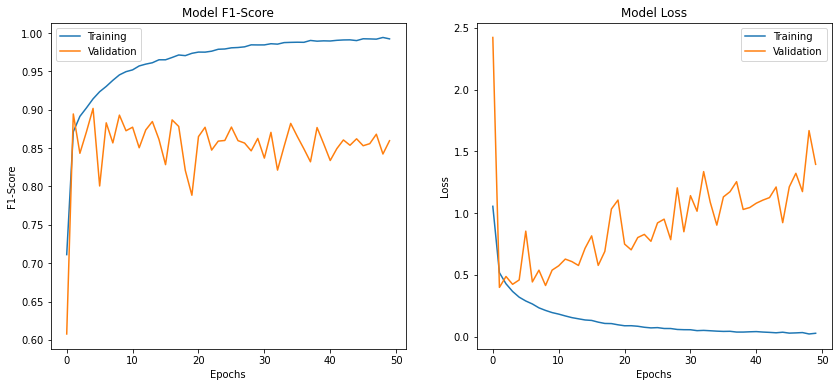

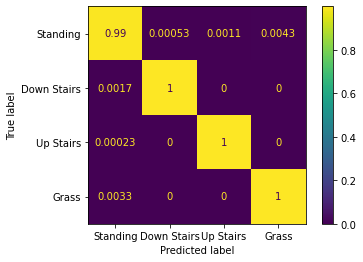

In [282]:
# Evaluate on Training set
evaluate_model(x_train, y_train, model_2, True, history)

### Evaluation

0.8606164928423626


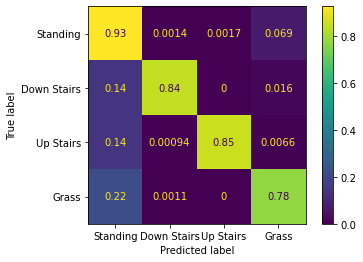

In [283]:
evaluate_model(x_test, y_test, model_2, plot=True, history=None)

In [284]:
for sub in sub_test:
    test_subject(model_2, sub, False)


Subject 4
0.7624800383370856

Subject 6
0.893416811146964



Subject 4
0.7624800383370856


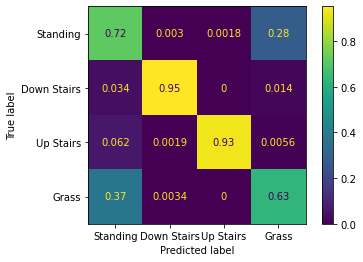

In [288]:
test_subject(model_2, '4')


Subject 6
0.893416811146964


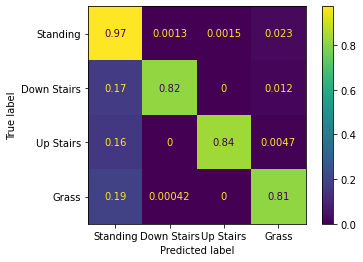

In [289]:
test_subject(model_2, '6')

### My Other Model

### Split labels

In [15]:
# Swap position of Down Stairs label with Grass label
def swap_label(labels):
    y_multi = np.copy(labels)
    for i, label in enumerate(y_multi):
        if label[1] == 1:
            label[1] = 0
            label[3] = 1
        elif label[3] == 1:
            label[3] = 0
            label[1] = 1
    return y_multi

In [96]:
y_mult_train = swap_label(y_train)

y_mult_test = swap_label(y_test)
x_mult_val, y_mult_val = x_val, swap_label(y_val)

print(y_mult_train.shape)
print(y_mult_test.shape)
print(y_mult_val.shape)

(139752, 4)
(27648, 4)
(8295, 4)


### Model 3 Params

In [118]:
# Model Params
LSTM_L1 = 256
DENSE_L2 = 256
DENSE_L31 = 128
DENSE_L32 = 128
arch_params_3 = {'layer1': LSTM_L1, 'layer2': DENSE_L2, 'layer31': DENSE_L31, 'layer32': DENSE_L32}

INIT_LR = 0.00001
EPOCHS = 10
BATCH_SIZE = 32

WEIGHTS = {0:1, 1:1.5, 2:1, 3:1.5}

fit_params_3 = {'lr': INIT_LR, 'epochs': EPOCHS, 'batch_size': BATCH_SIZE, 'weights': WEIGHTS}

### Multitask Model

In [119]:
## Model
# Shared Layers
window_input = keras.Input(shape=(80, 6), name="window_input")

layer1 = LSTM(units=384, return_sequences=False, name='lstm_layer1')(window_input)
#layer1 = BatchNormalization()(layer1)

# Path for Standing/Grass
layer21 = Dense(units=256, activation='relu', name='dense_layer21')(layer1)
#layer21 = BatchNormalization()(layer21)
layer21 = Dropout(rate=0.5)(layer21)

layer31 = Dense(units=128, activation='relu', name='dense_layer31')(layer21)
#layer31 = BatchNormalization()(layer31)
layer31 = Dropout(rate=0.4)(layer31)

layer41 = Dense(units=64, activation='relu', name='dense_layer41')(layer31)
#layer41 = BatchNormalization()(layer41)
layer41 = Dropout(rate=0.3)(layer41)

layer51 = Dense(units=32, activation='relu', name='dense_layer51')(layer41)
#layer51 = BatchNormalization()(layer51)
layer51 = Dropout(rate=0.2)(layer51)

layer61 = Dense(units=16, activation='relu', name='dense_layer61')(layer51)
#layer61 = BatchNormalization()(layer61)
layer61 = Dropout(rate=0.1)(layer61)

layer71 = Dense(units=4, activation='relu', name='dense_layer71')(layer61)
#layer71 = BatchNormalization()(layer71)

layer81 = Dense(units=2, name='dense_layer81')(layer71)

# Path for Stairs
layer22 = Dense(units=128, activation='relu', name='dense_layer22')(layer1)
#layer22 = BatchNormalization()(layer22)
layer22 = Dropout(rate=0.5)(layer22)

layer32 = Dense(units=2, name='dense_layer42')(layer22)

# Combine
out = concatenate([layer32, layer81])
out = Softmax()(out)

model_3 = keras.Model(inputs=window_input, outputs=out)

In [120]:
model_3, history = train_model(model_3, x_train, y_mult_train, x_test, y_mult_test, arch_params_3, fit_params_3)

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
window_input (InputLayer)       [(None, 80, 6)]      0                                            
__________________________________________________________________________________________________
lstm_layer1 (LSTM)              (None, 384)          600576      window_input[0][0]               
__________________________________________________________________________________________________
dense_layer21 (Dense)           (None, 256)          98560       lstm_layer1[0][0]                
__________________________________________________________________________________________________
dropout_108 (Dropout)           (None, 256)          0           dense_layer21[0][0]              
___________________________________________________________________________________________

0.9213862540271737


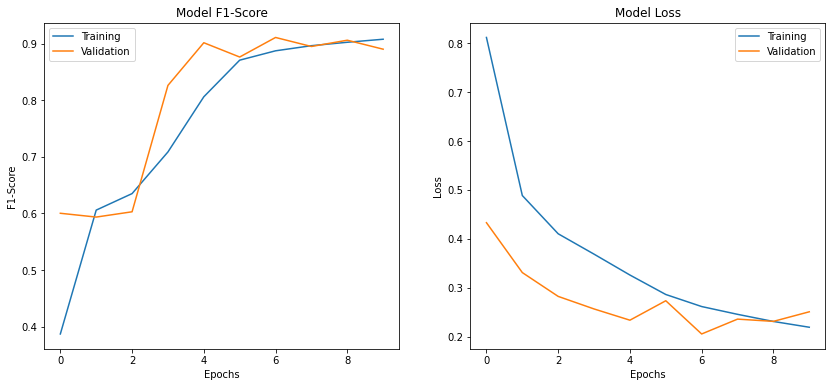

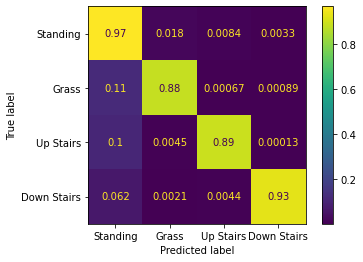

In [121]:
evaluate_model(x_train, y_mult_train, model_3, plot=True, history=history, swap=True)

### Evalulate Model

In [122]:
def test_mult_subject(model, subject, plot=True):
    x_seq, y_seq = None, None
    for trial, data in subjects_dict[subject].items():
        x_temp, y_temp = format_data(data, data_params)
        y_temp = swap_label(y_temp)

        if trial == list(subjects_dict[subject].keys())[0]:
            x_seq = x_temp
            y_seq = y_temp
        else:
            x_seq = np.concatenate((x_seq, x_temp), axis=0)
            y_seq = np.concatenate((y_seq, y_temp), axis=0)

    print('\nSubject {}'.format(subject))
    evaluate_model(x_seq, y_seq, model, plot, history=None, swap=True)

0.8899952720947831


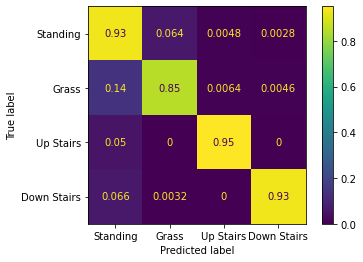

In [123]:
evaluate_model(x_test, y_mult_test, model_3, plot=True, history=None, swap=True)

In [124]:
for sub in sub_test:
    test_mult_subject(model_3, sub, False)


Subject 4
0.8262124965416149

Subject 6
0.9283810597621796



Subject 4
0.8262124965416149


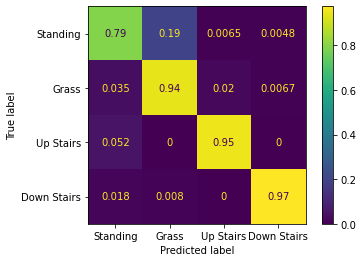

In [125]:
test_mult_subject(model_3, '4')


Subject 6
0.9283810597621796


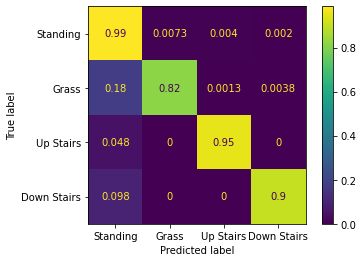

In [126]:
test_mult_subject(model_3, '6')

### Train and Test using Matt's

In [59]:
def build_model(lr):
    # Shared Layers
    window_input = keras.Input(shape=(80, 6), name="window_input")

    layer1 = LSTM(units=384, return_sequences=False, name='lstm_layer1')(window_input)
    #layer1 = BatchNormalization()(layer1)
    
    # Path for Standing/Grass kernel_regularizer=l1_l2(l1=0.01, l2=0.01)
    layer21 = Dense(units=256, activation='relu', name='dense_layer21')(layer1)
    layer21 = BatchNormalization()(layer21)
    layer21 = Dropout(rate=0.5)(layer21)

    layer31 = Dense(units=128, activation='relu', name='dense_layer31')(layer21)
    layer31 = BatchNormalization()(layer31)
    layer31 = Dropout(rate=0.4)(layer31)

    layer41 = Dense(units=64, activation='relu', name='dense_layer41')(layer31)
    layer41 = BatchNormalization()(layer41)
    layer41 = Dropout(rate=0.3)(layer41)

    layer51 = Dense(units=32, activation='relu', name='dense_layer51')(layer41)
    layer51 = BatchNormalization()(layer51)
    layer51 = Dropout(rate=0.2)(layer51)

    layer61 = Dense(units=16, activation='relu', name='dense_layer61')(layer51)
    layer61 = BatchNormalization()(layer61)
    layer61 = Dropout(rate=0.1)(layer61)

    layer71 = Dense(units=4, activation='relu', name='dense_layer71')(layer61)
    layer71 = BatchNormalization()(layer71)

    layer81 = Dense(units=2, name='dense_layer81')(layer71)

    # Path for Stairs
    layer22 = Dense(units=128, activation='relu', name='dense_layer22')(layer1)
    #layer22 = BatchNormalization()(layer22)
    layer22 = Dropout(rate=0.5)(layer22)

    layer32 = Dense(units=2, name='dense_layer42')(layer22)

    # Combine
    out = concatenate([layer32, layer81])
    out = Softmax()(out)

    model = keras.Model(inputs=window_input, outputs=out)
    
    opt = keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[F1Score(num_classes=NUM_CLASS, average='macro')])

    return model

In [60]:
KFOLD_NUM = 5
data_params = {'window': 2, 'stride': 0.2}
sub_train = ['1', '2', '3', '4', '5', '6', '7', '8']

x_matt, y_matt = format_combine_shuffle(subjects_dict, sub_train, data_params, shuffle=True, matt=True)
y_matt = swap_label(y_matt)

x_train_matt, x_test_matt, y_train_matt, y_test_matt = train_test_split(x_matt, y_matt, test_size=0.2)

In [61]:
x_train_matt.shape

(36237, 80, 6)

In [62]:
lr = 0.001
epochs = 20
batch_size = 32
weights = {0:1, 1:2, 2:2, 3:2}

acc_per_fold = []
kfold = KFold(n_splits=KFOLD_NUM)
current_fold = 1

for train, test in kfold.split(x_train_matt, y_train_matt):
    print("Performing KFold Number {}".format(current_fold))
    x_fold_train, x_fold_val, y_fold_train, y_fold_val = train_test_split(x_train_matt[train], y_train_matt[train], 
                                                                          test_size=0.2)
    
    model_4 = build_model(lr=lr)
    model_4.fit(x_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, validation_data=(x_fold_val, y_fold_val), 
            class_weight=weights, verbose=0)

    yhat_train_test = model_4.predict(x_train_matt[test])

    yhat_train_test = np.argmax(yhat_train_test, axis=1)
    y_train_test = np.argmax(y_train_matt[test], axis=1)

    fold_acc = f1_score(y_train_test, yhat_train_test, average='macro')

    print("Macro F1-Score: {:.2%}".format(fold_acc))

    acc_per_fold.append(fold_acc)
    current_fold += 1

acc = np.mean(acc_per_fold)

print("KFold Results:")
print("Macro F1-Score: {:.2%}".format(acc))

Performing KFold Number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 94.32%
Performing KFold Number 2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 96.14%
Performing KFold Number 3
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 95.16%
Performing KFold Number 4
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 96.06%
Performing KFold Number 5
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 96.14%
KFold Results:
Macro F1-Score: 95.56%


Train Macro F1-Score = 98.09%
Test Macro F1-Score = 95.99%


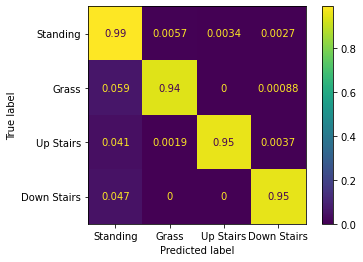

In [63]:
yhat_train = model_4.predict(x_train_matt)

yhat_train_cf = np.argmax(yhat_train, axis=1)
y_train_cf = np.argmax(y_train_matt, axis=1)
print('Train Macro F1-Score = {score:.2%}'.format(score=f1_score(y_train_cf, yhat_train_cf, average='macro')))

yhat_test = model_4.predict(x_test_matt)

yhat_test_cf = np.argmax(yhat_test, axis=1)
y_test_cf = np.argmax(y_test_matt, axis=1)
print('Test Macro F1-Score = {score:.2%}'.format(score=f1_score(y_test_cf, yhat_test_cf, average='macro')))

cm = confusion_matrix(y_test_cf, yhat_test_cf, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standing','Grass','Up Stairs','Down Stairs'])
disp.plot();

### Train using Matt's Custom Kfold

In [64]:
class SubjectFold():
    def __init__(self, X, Y):
        self.X = None
        self.Y = None
        self.slices = {}
        self.keys = list(X.keys())

        for item in X:
            if (self.X is None):
                self.X = X[item]
                self.Y = Y[item]
                self.slices[item] = (0, X[item].shape[0])
            else:
                self.slices[item] = (self.X.shape[0], self.X.shape[0]+X[item].shape[0])
                self.X = np.concatenate((self.X, X[item]))
                self.Y = np.concatenate((self.Y, Y[item]))

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if (self.n < len(self.keys)):
            key = self.keys[self.n]
            slices = self.slices[key]
            self.n += 1
            X_test = self.X[slices[0]:slices[1]]
            Y_test = self.Y[slices[0]:slices[1]]
            X_train = np.concatenate((self.X[:slices[0]], self.X[slices[1]:]))
            Y_train = np.concatenate((self.Y[:slices[0]], self.Y[slices[1]:]))
            return key, X_train, X_test, Y_train, Y_test
        else:
            raise StopIteration

In [65]:
data_params = {'window': 2, 'stride': 0.2}

x_dict, y_dict = {}, {}
for i, sub in enumerate(sub_train):
    temp = [sub]
    x_temp, y_temp = format_combine_shuffle(subjects_dict, temp, data_params, shuffle=True)
    y_temp = swap_label(y_temp)
    
    x_dict[i + 1] = x_temp
    y_dict[i + 1] = y_temp

In [66]:
lr = 0.001
epochs = 20
batch_size = 32
weights = {0:1, 1:2, 2:2, 3:2}

acc_per_fold = []
kfold = SubjectFold(x_dict, y_dict)

for key, x_train, x_test, y_train, y_test in kfold:
    print("Performing KFold Number {}".format(key))
    x_fold_train, x_fold_val, y_fold_train, y_fold_val = train_test_split(x_train, y_train, test_size=0.2)
    
    model = build_model(lr=lr)
    model.fit(x_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, validation_data=(x_fold_val, y_fold_val), 
              class_weight=weights, verbose=0)

    yhat_train_test = model.predict(x_test)

    yhat_train_test = np.argmax(yhat_train_test, axis=1)
    y_train_test = np.argmax(y_test, axis=1)

    fold_acc = f1_score(y_train_test, yhat_train_test, average='macro')

    print("Macro F1-Score: {:.2%}".format(fold_acc))

    acc_per_fold.append(fold_acc)

acc = np.mean(acc_per_fold)

print("KFold Results:")
print("Macro F1-Score: {:.2%}".format(acc))

Performing KFold Number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 80.76%
Performing KFold Number 2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 73.98%
Performing KFold Number 3
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 57.86%
Performing KFold Number 4
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 75.33%
Performing KFold Number 5
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 81.76%
Performing KFold Number 6
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 90.04%
Performing KFold Number 7
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 81.14%
Performing KFold Number 8
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Macro F1-Score: 52.00%
KFold Results:
Macro F1-Score: 74.11%


# Generate Test Predictions

In [94]:
# Data Format Params
data_params = {'window': 2, 'stride': 0.2}

# Subjects to train on
sub_train = ['1', '2', '3', '4', '5', '6', '7', '8']
x_train, y_train = format_combine_shuffle(subjects_dict, sub_train, data_params, shuffle=True)
y_train = swap_label(y_train)

In [95]:
lr = 0.001
epochs = 20
batch_size = 32
weights = {0:1, 1:2, 2:2, 3:2}

final_model = build_model(lr)

In [96]:
final_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=weights, verbose=0)

  ...
    to  
  ['...']


Test Macro F1-Score = 99.10%


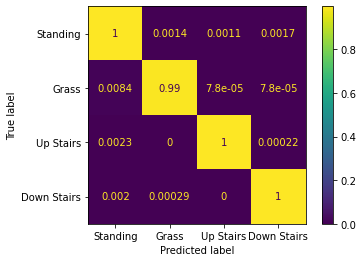

In [97]:
yhat = final_model.predict(x_train)
yhat_cf = np.argmax(yhat, axis=1)
y_cf = np.argmax(y_train, axis=1)
print('Test Macro F1-Score = {score:.2%}'.format(score=f1_score(y_cf, yhat_cf, average='macro')))

cm = confusion_matrix(y_cf, yhat_cf, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standing','Grass','Up Stairs','Down Stairs'])
disp.plot();

In [98]:
test_files = listdir('data/TestData')
test_files = ['data/TestData/' + name for name in files]

subjects_test = {}

for sub_num in range(9, 13):
    subjects_test[str(sub_num)] = {}
    prefix = 'data/TestData/subject_0{:02d}_01__'.format(sub_num, trial_num)

    ## X
    # Read subject_00A_0B__x_time.csv
    x_time = pd.read_csv(prefix + 'x_time.csv', names=['sec'])
    # Read subject_00A_0B__x.csv
    x_data = pd.read_csv(prefix + 'x.csv', names=features[:-1])

    # Concatenate time with data, and set time as index
    x_result = pd.concat([x_time, x_data], axis=1)
    x_result = x_result.set_index('sec')

    subjects_test[str(sub_num)] = x_result

In [99]:
subjects_test['9'].head()

,x accelerometer,y accelerometer,z accelerometer,x gyroscope,y gyroscope,z gyroscope
sec,,,,,,
0.000,0.396845,8.710000,-4.476044,0.001111,-0.008889,0.004137
0.025,0.413795,8.706898,-4.456205,0.000000,-0.002838,0.007162
0.050,0.423914,8.707828,-4.502172,0.002037,0.001111,0.007778
0.075,0.442980,8.718078,-4.502980,0.000403,0.004648,0.008384
0.100,0.485234,8.725234,-4.520000,-0.000020,0.006667,0.007778


In [122]:
# Formats data into epochs, same as Matt's format_data
def format_test_data(data, data_params):
    window = data_params['window']
    stride = data_params['stride']
    
    num_epochs = int((data.index[-1] - window) / stride)
    x_epochs = np.zeros((num_epochs, window * X_RATE, NUM_SENSORS))

    np_data = data.to_numpy()
    x_np = np_data

    window_size = int(X_RATE * window)

    # window epoch calculation stuff
    for i in range(num_epochs):
        offset = int(X_RATE * stride * i)
        x_epochs[i] = x_np[offset : window_size + offset]

    return x_epochs

In [137]:
test_dir = 'data/TestData/LabelPredictions/'
X_Time_Window = 2
Y_Time_Step_Size = 0.2
Y_RATE = 10

yhat_write = None
yhat_write_ext = None

def predict_write_test(model, sub_dict, data_params):
    for sub, data in sub_dict.items():
        prefix = 'data/TestData/subject_{:03d}_01__'.format(int(sub))
        
        x_final_test = format_test_data(data, data_params)
        
        yhat = model.predict(x_final_test)
        yhat_write = np.argmax(yhat, axis=1)
        for i, label in enumerate(yhat_write):
            if label == 1:
                yhat_write[i] = 3
            elif label == 3:
                yhat_write[i] = 1
        
        yhat_write_ext = np.repeat(yhat_write, 2)
        yhat_len = yhat_write_ext.shape[0]
        
        y_time = pd.read_csv(prefix + 'y_time.csv', names=['sec'])
        time_len = len(y_time.index)
        
        extend_len = time_len - yhat_len

        if extend_len != 0:
            extend = np.repeat(yhat_write_ext[-1], extend_len - 1)
            yhat_write_ext = np.append(yhat_write_ext, extend)
            
        df_yhat = pd.DataFrame(yhat_write_ext)
        
        write_dir = test_dir + 'subject_{:03d}_01__y.csv'.format(int(sub))
        df_yhat.to_csv(write_dir, index=False)

In [138]:
data_test_params = {'window': 2, 'stride': 0.2}

predict_write_test(final_model, subjects_test, data_test_params)

9498
9476
12270
12250
12940
12920
11330
11308


In [142]:
submission_2 = pd.read_csv('data/TestData/LabelPredictions/Submission_2/subject_009_01__y.csv')
submission_2 = submission_2.values

submission_3 = pd.read_csv('data/TestData/LabelPredictions/subject_009_01__y.csv')
submission_3 = submission_3.values

submission_2.shape == submission_3.shape

True

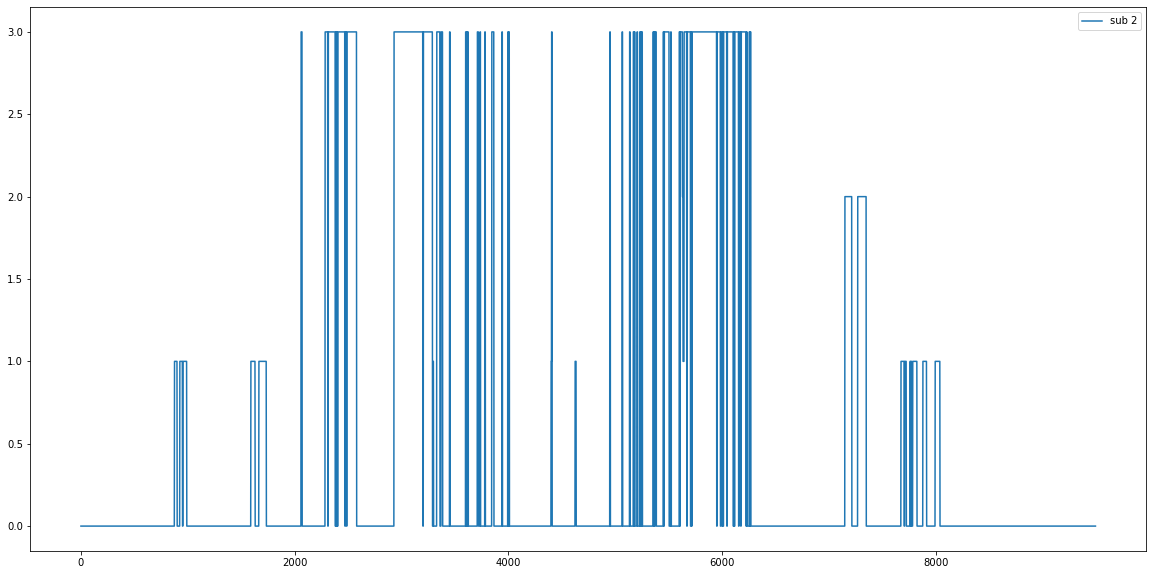

In [144]:
plt.figure(figsize=(20, 10))
plt.plot(submission_2, label="sub 2")
plt.legend()
plt.show();

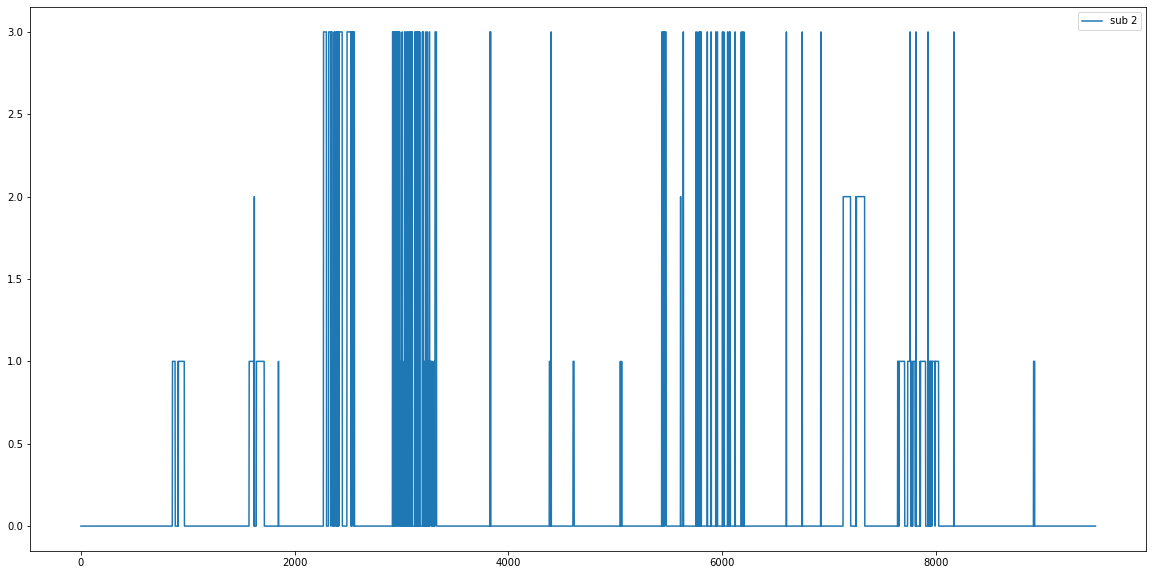

In [145]:
plt.figure(figsize=(20, 10))
plt.plot(submission_3, label="sub 3")
plt.legend()
plt.show();